In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import reduce

# Definition of the EncDec-AD model

In [2]:
# decoder input: original time series value at last time step

class EncDecAD(object):

    def __init__(self, hidden_num, inputs, cell=None, optimizer=None, reverse=True, decode_without_input=False,):

        self.batch_num = inputs[0].get_shape().as_list()[0]
        self.elem_num = inputs[0].get_shape().as_list()[1]
        if cell is None:
            self._enc_cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
            self._dec_cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)

        else:
            self._enc_cell = cell
            self._dec_cell = cell

        with tf.variable_scope('encoder'):
            (self.z_codes, self.enc_state) = tf.contrib.rnn.static_rnn(self._enc_cell, inputs, dtype=tf.float32)

        with tf.variable_scope('decoder') as vs:
            dec_weight_ = tf.Variable(tf.truncated_normal([hidden_num,
                    self.elem_num], dtype=tf.float32), name='dec_weight')

            dec_bias_ = tf.Variable(tf.constant(0.1,shape=[self.elem_num],dtype=tf.float32), name='dec_bias')

            if decode_without_input:
                dec_inputs = [tf.zeros(tf.shape(inputs[0]),dtype=tf.float32) for _ in range(len(inputs))]
                (dec_outputs, dec_state) = tf.contrib.rnn.static_rnn(self._dec_cell, dec_inputs, initial_state=self.enc_state, dtype=tf.float32)

                if reverse:
                    dec_outputs = dec_outputs[::-1]
                    
                dec_output_ = tf.transpose(tf.stack(dec_outputs), [1, 0,2])
                dec_weight_ = tf.tile(tf.expand_dims(dec_weight_, 0),[self.batch_num, 1, 1])
                self.output_ = tf.matmul(dec_output_, dec_weight_) + dec_bias_


            else:
                dec_state = self.enc_state
                dec_input_ = tf.zeros(tf.shape(inputs[0]),dtype=tf.float32)
                dec_outputs = []
                
                for step in range(len(inputs)):
                    if step > 0:
                        vs.reuse_variables()
                    (dec_input_, dec_state) =self._dec_cell(dec_input_, dec_state)
                    dec_input_ = tf.matmul(dec_input_, dec_weight_) + dec_bias_
                    dec_outputs.append(dec_input_)

                if reverse:
                    dec_outputs = dec_outputs[::-1]

                self.output_ = tf.transpose(tf.stack(dec_outputs), [1, 0, 2])
        self.input_ = tf.transpose(tf.stack(inputs), [1, 0, 2])
        self.loss = tf.reduce_mean(tf.square(self.input_ - self.output_))

        if optimizer is None:
            self.train = tf.train.AdamOptimizer().minimize(self.loss)

        else:
            self.train = optimizer.minimize(self.loss)
        

# Load Power Demand Dataset

In [3]:
# The dataset is divided into 6 parts, namely training_normal, validation_1,
#validation_2, test_normal, validation_anomaly, test_anomaly.

root = "C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/preprocessed/PowerDemand/6_subsets/"

sn = pd.read_csv(root + "training_normal.csv",header=None)
vn1 = pd.read_csv(root + "validation_1.csv",header=None)
vn2 = pd.read_csv(root + "validation_2.csv",header=None)
tn = pd.read_csv(root + "test_normal.csv",header=None)

va = pd.read_csv(root + "validation_anomaly.csv",header=None)
ta = pd.read_csv(root + "test_anomaly.csv",header=None)    


# Initialization

In [4]:
tf.reset_default_graph()

batch_num = 3

hidden_num = 40

step_num = 84

elem_num = sn.shape[1]

iteration = 5000

modlepath = "C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v4.ckpt"

In [5]:
t1 = sn.shape[0]//step_num
t2 = va.shape[0]//step_num
t3 = vn1.shape[0]//step_num
t4 = vn2.shape[0]//step_num
t5 = tn.shape[0]//step_num
t6 = ta.shape[0]//step_num

sn_list = [sn[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t1)]
va_list = [va[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t2)]
vn1_list = [vn1[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t3)]
vn2_list = [vn2[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t4)]

tn_list = [tn[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t5)]
ta_list = [ta[step_num*i:step_num*(i+1)].as_matrix().reshape(-1,1) for i in range(t6)]


In [6]:
# input placeholder
p_input = tf.placeholder(tf.float32, shape=(batch_num, step_num, elem_num))
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)]

# define cell
#cell = tf.nn.rnn_cell.LSTMCell(hidden_num, use_peepholes=True)
cell = None

In [7]:
ae = EncDecAD(hidden_num, p_inputs,cell=cell,
                     decode_without_input=True)

# Training

iter 1: 0.132229
iter 2: 0.119934
iter 3: 0.0839821
iter 4: 0.0540413
iter 5: 0.0738546
iter 6: 0.0429456
iter 7: 0.0394263
iter 8: 0.0495563
iter 9: 0.0404639
iter 10: 0.0397191
iter 11: 0.042595
iter 12: 0.0468451
iter 13: 0.0456106
iter 14: 0.0423445
iter 15: 0.0410123
iter 16: 0.0375498
iter 17: 0.0372834
iter 18: 0.0392817
iter 19: 0.0386747
iter 20: 0.0327756
iter 21: 0.0364577
iter 22: 0.0302546
iter 23: 0.0428692
iter 24: 0.0363119
iter 25: 0.0401772
iter 26: 0.041739
iter 27: 0.0313417
iter 28: 0.0366964
iter 29: 0.0302377
iter 30: 0.0368233
iter 31: 0.0332266
iter 32: 0.038485
iter 33: 0.0339578
iter 34: 0.0336453
iter 35: 0.0375037
iter 36: 0.034823
iter 37: 0.0386237
iter 38: 0.035759
iter 39: 0.0345723
iter 40: 0.0325137
iter 41: 0.038916
iter 42: 0.0360369
iter 43: 0.0424258
iter 44: 0.0400821
iter 45: 0.0302226
iter 46: 0.0332601
iter 47: 0.0373896
iter 48: 0.0333254
iter 49: 0.0320736
iter 50: 0.0345966
iter 51: 0.0379561
iter 52: 0.0368514
iter 53: 0.0336202
iter 54: 0

iter 424: 0.00987324
iter 425: 0.0096578
iter 426: 0.0112377
iter 427: 0.0085141
iter 428: 0.0083214
iter 429: 0.0092732
iter 430: 0.00830669
iter 431: 0.00858733
iter 432: 0.00641178
iter 433: 0.00822478
iter 434: 0.00762957
iter 435: 0.00825098
iter 436: 0.00864575
iter 437: 0.0076251
iter 438: 0.00673931
iter 439: 0.00893125
iter 440: 0.00757175
iter 441: 0.0089269
iter 442: 0.00812193
iter 443: 0.00700104
iter 444: 0.00704616
iter 445: 0.00905259
iter 446: 0.00622641
iter 447: 0.00540158
iter 448: 0.0105577
iter 449: 0.00725581
iter 450: 0.00530985
iter 451: 0.0069271
iter 452: 0.0077295
iter 453: 0.0067225
iter 454: 0.00723344
iter 455: 0.0052161
iter 456: 0.00465909
iter 457: 0.00568525
iter 458: 0.00460192
iter 459: 0.0059786
iter 460: 0.00687612
iter 461: 0.0080847
iter 462: 0.00580159
iter 463: 0.00563938
iter 464: 0.00480316
iter 465: 0.00619274
iter 466: 0.00685188
iter 467: 0.00714637
iter 468: 0.00487708
iter 469: 0.00510378
iter 470: 0.00487877
iter 471: 0.00513134
iter 4

iter 817: 0.00438176
iter 818: 0.00510591
iter 819: 0.00582732
iter 820: 0.0049907
iter 821: 0.00433829
iter 822: 0.00423659
iter 823: 0.00568834
iter 824: 0.00362942
iter 825: 0.00600981
iter 826: 0.00534185
iter 827: 0.00467662
iter 828: 0.00376103
iter 829: 0.00564501
iter 830: 0.00819054
iter 831: 0.00404852
iter 832: 0.00517846
iter 833: 0.00469189
iter 834: 0.0042967
iter 835: 0.00451073
iter 836: 0.00438844
iter 837: 0.00677492
iter 838: 0.0048041
iter 839: 0.00570958
iter 840: 0.00558036
iter 841: 0.00501546
iter 842: 0.00383349
iter 843: 0.00472797
iter 844: 0.00413381
iter 845: 0.0045721
iter 846: 0.00502167
iter 847: 0.00349348
iter 848: 0.00464436
iter 849: 0.00777216
iter 850: 0.00451652
iter 851: 0.00536396
iter 852: 0.0058607
iter 853: 0.00514807
iter 854: 0.00534373
iter 855: 0.00450347
iter 856: 0.00484091
iter 857: 0.0061083
iter 858: 0.00569372
iter 859: 0.0046744
iter 860: 0.00512875
iter 861: 0.00406392
iter 862: 0.00543337
iter 863: 0.00543259
iter 864: 0.00617311

iter 1204: 0.00374792
iter 1205: 0.00505488
iter 1206: 0.00300051
iter 1207: 0.00437
iter 1208: 0.00413839
iter 1209: 0.00401376
iter 1210: 0.0027771
iter 1211: 0.00506639
iter 1212: 0.00436453
iter 1213: 0.00560545
iter 1214: 0.00386032
iter 1215: 0.00415446
iter 1216: 0.00511504
iter 1217: 0.00360107
iter 1218: 0.00440022
iter 1219: 0.0047638
iter 1220: 0.0045287
iter 1221: 0.00320662
iter 1222: 0.00412217
iter 1223: 0.002688
iter 1224: 0.00517108
iter 1225: 0.00276111
iter 1226: 0.00496771
iter 1227: 0.00454153
iter 1228: 0.0044174
iter 1229: 0.003548
iter 1230: 0.00358858
iter 1231: 0.00385847
iter 1232: 0.00355495
iter 1233: 0.00433661
iter 1234: 0.00338407
iter 1235: 0.00345508
iter 1236: 0.00273807
iter 1237: 0.00502345
iter 1238: 0.00293375
iter 1239: 0.00320775
iter 1240: 0.00343231
iter 1241: 0.00354174
iter 1242: 0.00317043
iter 1243: 0.00314444
iter 1244: 0.00347486
iter 1245: 0.0033877
iter 1246: 0.00404531
iter 1247: 0.00467082
iter 1248: 0.00435217
iter 1249: 0.00340167


iter 1584: 0.00354425
iter 1585: 0.00296827
iter 1586: 0.00323001
iter 1587: 0.00253589
iter 1588: 0.00373225
iter 1589: 0.00392259
iter 1590: 0.00300653
iter 1591: 0.00349483
iter 1592: 0.0035237
iter 1593: 0.00296871
iter 1594: 0.00234303
iter 1595: 0.00389326
iter 1596: 0.00337295
iter 1597: 0.00286333
iter 1598: 0.00321588
iter 1599: 0.00302626
iter 1600: 0.00370837
iter 1601: 0.00326326
iter 1602: 0.0029232
iter 1603: 0.00337659
iter 1604: 0.00291348
iter 1605: 0.00234352
iter 1606: 0.0036835
iter 1607: 0.00284517
iter 1608: 0.00449993
iter 1609: 0.00398243
iter 1610: 0.00277556
iter 1611: 0.00227288
iter 1612: 0.00383669
iter 1613: 0.00390939
iter 1614: 0.00406352
iter 1615: 0.00328522
iter 1616: 0.00453791
iter 1617: 0.00323422
iter 1618: 0.0036578
iter 1619: 0.00306131
iter 1620: 0.00338537
iter 1621: 0.00269949
iter 1622: 0.00369478
iter 1623: 0.00353777
iter 1624: 0.00339629
iter 1625: 0.00410448
iter 1626: 0.00259621
iter 1627: 0.00375214
iter 1628: 0.00250177
iter 1629: 0.0

iter 1960: 0.00234871
iter 1961: 0.00284225
iter 1962: 0.00234293
iter 1963: 0.00239136
iter 1964: 0.00307571
iter 1965: 0.00263898
iter 1966: 0.00209233
iter 1967: 0.00234164
iter 1968: 0.00222734
iter 1969: 0.0026393
iter 1970: 0.00280407
iter 1971: 0.00238251
iter 1972: 0.00475212
iter 1973: 0.0029234
iter 1974: 0.00343632
iter 1975: 0.00219226
iter 1976: 0.00355864
iter 1977: 0.0021662
iter 1978: 0.00304186
iter 1979: 0.00287764
iter 1980: 0.00313215
iter 1981: 0.00233286
iter 1982: 0.00304198
iter 1983: 0.00190436
iter 1984: 0.002725
iter 1985: 0.00360091
iter 1986: 0.00380046
iter 1987: 0.0033718
iter 1988: 0.00267049
iter 1989: 0.00256542
iter 1990: 0.0025653
iter 1991: 0.00240045
iter 1992: 0.00241885
iter 1993: 0.00362592
iter 1994: 0.00324015
iter 1995: 0.00269887
iter 1996: 0.00238973
iter 1997: 0.00259689
iter 1998: 0.00228797
iter 1999: 0.00231418
iter 2000: 0.002513
iter 2001: 0.00258322
iter 2002: 0.00251513
iter 2003: 0.00205443
iter 2004: 0.0037583
iter 2005: 0.0023175

iter 2340: 0.00160083
iter 2341: 0.00224769
iter 2342: 0.00235184
iter 2343: 0.00191425
iter 2344: 0.00271957
iter 2345: 0.0019812
iter 2346: 0.00222251
iter 2347: 0.00174874
iter 2348: 0.0017261
iter 2349: 0.00266635
iter 2350: 0.00180812
iter 2351: 0.00172183
iter 2352: 0.00285591
iter 2353: 0.00172834
iter 2354: 0.00211818
iter 2355: 0.00190763
iter 2356: 0.00234196
iter 2357: 0.00186069
iter 2358: 0.00265295
iter 2359: 0.00273004
iter 2360: 0.00277256
iter 2361: 0.00209813
iter 2362: 0.00256805
iter 2363: 0.00158315
iter 2364: 0.00276597
iter 2365: 0.00180516
iter 2366: 0.00187601
iter 2367: 0.00186267
iter 2368: 0.00183563
iter 2369: 0.00264641
iter 2370: 0.00185402
iter 2371: 0.00171225
iter 2372: 0.0014693
iter 2373: 0.00199967
iter 2374: 0.00177018
iter 2375: 0.00168937
iter 2376: 0.00180675
iter 2377: 0.00328141
iter 2378: 0.00251995
iter 2379: 0.00147408
iter 2380: 0.00222497
iter 2381: 0.00215325
iter 2382: 0.00222949
iter 2383: 0.00348046
iter 2384: 0.0021428
iter 2385: 0.0

iter 2715: 0.00197688
iter 2716: 0.00220457
iter 2717: 0.00199169
iter 2718: 0.00240516
iter 2719: 0.00391912
iter 2720: 0.0027589
iter 2721: 0.00181298
iter 2722: 0.00237805
iter 2723: 0.0023161
iter 2724: 0.00405716
iter 2725: 0.00226511
iter 2726: 0.00192825
iter 2727: 0.00219092
iter 2728: 0.00254387
iter 2729: 0.00299171
iter 2730: 0.00130056
iter 2731: 0.0020021
iter 2732: 0.00222601
iter 2733: 0.00139619
iter 2734: 0.0024167
iter 2735: 0.00206471
iter 2736: 0.00165617
iter 2737: 0.0018299
iter 2738: 0.00200856
iter 2739: 0.00214309
iter 2740: 0.00146514
iter 2741: 0.00143954
iter 2742: 0.00148288
iter 2743: 0.00137492
iter 2744: 0.00141819
iter 2745: 0.00157597
iter 2746: 0.00175529
iter 2747: 0.00149946
iter 2748: 0.00215905
iter 2749: 0.00139488
iter 2750: 0.00153721
iter 2751: 0.00185011
iter 2752: 0.0011982
iter 2753: 0.0013663
iter 2754: 0.00157734
iter 2755: 0.00170087
iter 2756: 0.00157324
iter 2757: 0.00143112
iter 2758: 0.00140472
iter 2759: 0.00179313
iter 2760: 0.0016

iter 3090: 0.0015287
iter 3091: 0.00127151
iter 3092: 0.00163715
iter 3093: 0.001911
iter 3094: 0.00152668
iter 3095: 0.000982313
iter 3096: 0.00210352
iter 3097: 0.00169663
iter 3098: 0.00165354
iter 3099: 0.00153515
iter 3100: 0.00148962
iter 3101: 0.00135574
iter 3102: 0.00214872
iter 3103: 0.00145867
iter 3104: 0.00211376
iter 3105: 0.00146379
iter 3106: 0.00146637
iter 3107: 0.00148436
iter 3108: 0.00180365
iter 3109: 0.00145972
iter 3110: 0.00222296
iter 3111: 0.00141822
iter 3112: 0.00174978
iter 3113: 0.00197965
iter 3114: 0.00193018
iter 3115: 0.00133713
iter 3116: 0.00171841
iter 3117: 0.00134689
iter 3118: 0.00141811
iter 3119: 0.00112293
iter 3120: 0.00127482
iter 3121: 0.00216816
iter 3122: 0.00274856
iter 3123: 0.00110721
iter 3124: 0.00193424
iter 3125: 0.00181843
iter 3126: 0.00214086
iter 3127: 0.00208004
iter 3128: 0.00174065
iter 3129: 0.00197993
iter 3130: 0.00233732
iter 3131: 0.00142288
iter 3132: 0.00245275
iter 3133: 0.00266615
iter 3134: 0.00216543
iter 3135: 0

iter 3467: 0.00118611
iter 3468: 0.00221376
iter 3469: 0.00146187
iter 3470: 0.00138193
iter 3471: 0.00214456
iter 3472: 0.00169816
iter 3473: 0.00102222
iter 3474: 0.00340951
iter 3475: 0.00196282
iter 3476: 0.00227235
iter 3477: 0.00176362
iter 3478: 0.000903511
iter 3479: 0.00187034
iter 3480: 0.000706314
iter 3481: 0.00150071
iter 3482: 0.0012423
iter 3483: 0.00264818
iter 3484: 0.00191137
iter 3485: 0.00123332
iter 3486: 0.0017368
iter 3487: 0.00139242
iter 3488: 0.00218481
iter 3489: 0.00200612
iter 3490: 0.00235625
iter 3491: 0.00148643
iter 3492: 0.00160311
iter 3493: 0.00139201
iter 3494: 0.00177281
iter 3495: 0.00229606
iter 3496: 0.00140536
iter 3497: 0.00260229
iter 3498: 0.00190157
iter 3499: 0.00131884
iter 3500: 0.00083725
iter 3501: 0.00217559
iter 3502: 0.0025982
iter 3503: 0.00247918
iter 3504: 0.00260166
iter 3505: 0.00461941
iter 3506: 0.00159774
iter 3507: 0.00236167
iter 3508: 0.00215135
iter 3509: 0.00266562
iter 3510: 0.0013254
iter 3511: 0.00169917
iter 3512: 0

iter 3846: 0.00373619
iter 3847: 0.00273494
iter 3848: 0.00178708
iter 3849: 0.00383336
iter 3850: 0.00234853
iter 3851: 0.0027358
iter 3852: 0.00280381
iter 3853: 0.00170121
iter 3854: 0.0042628
iter 3855: 0.00167689
iter 3856: 0.00385083
iter 3857: 0.00307427
iter 3858: 0.00244385
iter 3859: 0.00357601
iter 3860: 0.00191323
iter 3861: 0.00239909
iter 3862: 0.00225273
iter 3863: 0.00263203
iter 3864: 0.00301859
iter 3865: 0.00136345
iter 3866: 0.00288689
iter 3867: 0.00179941
iter 3868: 0.00238912
iter 3869: 0.0024133
iter 3870: 0.00179969
iter 3871: 0.00175966
iter 3872: 0.00250989
iter 3873: 0.00162478
iter 3874: 0.00193072
iter 3875: 0.00165159
iter 3876: 0.00203342
iter 3877: 0.00231853
iter 3878: 0.00133885
iter 3879: 0.00271524
iter 3880: 0.001417
iter 3881: 0.00182995
iter 3882: 0.0026299
iter 3883: 0.00125733
iter 3884: 0.00216005
iter 3885: 0.00154979
iter 3886: 0.00112883
iter 3887: 0.00231305
iter 3888: 0.0014874
iter 3889: 0.00208845
iter 3890: 0.00164444
iter 3891: 0.0018

iter 4220: 0.00120774
iter 4221: 0.00118627
iter 4222: 0.00118727
iter 4223: 0.00150645
iter 4224: 0.0013147
iter 4225: 0.00124243
iter 4226: 0.00185429
iter 4227: 0.00118005
iter 4228: 0.00212438
iter 4229: 0.00188798
iter 4230: 0.00204176
iter 4231: 0.00181745
iter 4232: 0.00139501
iter 4233: 0.00120842
iter 4234: 0.00172198
iter 4235: 0.00123463
iter 4236: 0.00122169
iter 4237: 0.00131373
iter 4238: 0.000959915
iter 4239: 0.00130833
iter 4240: 0.00181012
iter 4241: 0.00141827
iter 4242: 0.00133634
iter 4243: 0.00139818
iter 4244: 0.00124356
iter 4245: 0.00207091
iter 4246: 0.00129767
iter 4247: 0.00128669
iter 4248: 0.00160635
iter 4249: 0.0012345
iter 4250: 0.00121249
iter 4251: 0.00109122
iter 4252: 0.00120897
iter 4253: 0.0011109
iter 4254: 0.00258977
iter 4255: 0.00116486
iter 4256: 0.00105529
iter 4257: 0.00109696
iter 4258: 0.00085309
iter 4259: 0.00127898
iter 4260: 0.00127716
iter 4261: 0.00170066
iter 4262: 0.00163603
iter 4263: 0.00124054
iter 4264: 0.00110613
iter 4265: 0

iter 4598: 0.00127842
iter 4599: 0.00210976
iter 4600: 0.00171362
iter 4601: 0.00177101
iter 4602: 0.00246987
iter 4603: 0.00166285
iter 4604: 0.00131632
iter 4605: 0.00316664
iter 4606: 0.0011805
iter 4607: 0.00124646
iter 4608: 0.00178472
iter 4609: 0.00199674
iter 4610: 0.00106103
iter 4611: 0.00193295
iter 4612: 0.00146937
iter 4613: 0.00142255
iter 4614: 0.000890459
iter 4615: 0.00101392
iter 4616: 0.00170824
iter 4617: 0.00158724
iter 4618: 0.00123834
iter 4619: 0.00116952
iter 4620: 0.00205787
iter 4621: 0.00182706
iter 4622: 0.00177393
iter 4623: 0.00233468
iter 4624: 0.00202363
iter 4625: 0.00138452
iter 4626: 0.00162462
iter 4627: 0.00150067
iter 4628: 0.0012714
iter 4629: 0.0012536
iter 4630: 0.00129236
iter 4631: 0.00196207
iter 4632: 0.00124435
iter 4633: 0.00225788
iter 4634: 0.00100478
iter 4635: 0.00178664
iter 4636: 0.0013807
iter 4637: 0.00161941
iter 4638: 0.00158803
iter 4639: 0.00223774
iter 4640: 0.002137
iter 4641: 0.00215033
iter 4642: 0.00268528
iter 4643: 0.00

iter 4972: 0.00188189
iter 4973: 0.00163875
iter 4974: 0.00103224
iter 4975: 0.00185705
iter 4976: 0.00284229
iter 4977: 0.00124735
iter 4978: 0.000744641
iter 4979: 0.00170471
iter 4980: 0.00159249
iter 4981: 0.00129621
iter 4982: 0.00221312
iter 4983: 0.00118164
iter 4984: 0.00180912
iter 4985: 0.00151641
iter 4986: 0.00182377
iter 4987: 0.00153221
iter 4988: 0.00150914
iter 4989: 0.00166499
iter 4990: 0.0016123
iter 4991: 0.00163998
iter 4992: 0.001345
iter 4993: 0.00206146
iter 4994: 0.00195611
iter 4995: 0.0013965
iter 4996: 0.00125605
iter 4997: 0.00155257
iter 4998: 0.00262744
iter 4999: 0.00202738
iter 5000: 0.00224072
Model saved in file: C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v4.ckpt


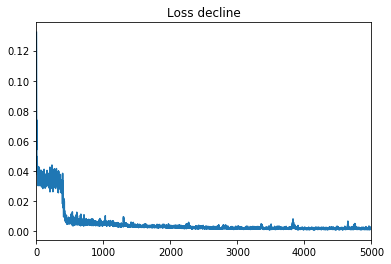

In [8]:
saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss = []
    for i in range(iteration):
        data =[]
        for temp in range(batch_num):
            ind = np.random.randint(0,len(sn_list)-1)
            sub = sn_list[ind]
            data.append(sub)
        data = np.array(data)
        (loss_val, _) = sess.run([ae.loss, ae.train], {p_input: data})
        loss.append(loss_val)
        print('iter %d:' % (i + 1), loss_val)
    pd.Series(loss).plot(title="Loss decline")
    save_path = saver.save(sess, modlepath)
    print("Model saved in file: %s" % save_path) 

# Calculate parameters using Vn1 dataset 

In [9]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')

    data = np.array(vn1_list)
    (input_, output_) = sess.run([ae.input_, ae.output_], {p_input: data})

    err_vec = abs(input_ - output_).reshape(-1,step_num)
    mu = np.mean(err_vec,axis=0)
    sigma = np.cov(err_vec.T)
    print("Got parameters mu and sigma.")

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v4.ckpt
Model restored.
Initialized
Got parameters mu and sigma.


# Calculate anomaly score, get threshold t using Vn2 and Va dataset.

In [10]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    for count in range(len(vn2_list)//batch_num):
        normal_sub = np.array(vn2_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(va_list)//batch_num):
        abnormal_sub = np.array(va_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             

    print('Finished')


INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v4.ckpt
Model restored.
Initialized
Finished


In [11]:
# the threshold leads to best f1 sore
def evaluate(threshold):
    beta = 0.5
    tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
    fp = len(abnormal_score)-tp
    fn = np.array(normal_score)[np.array(normal_score)>threshold].size
    tn = len(normal_score)- fn
    P = tp/(tp+fp)
    R = tp/(tp+fn)
    fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
    return fbeta


upper = np.median(np.array(abnormal_score))
lower = np.median(np.array(normal_score)) 
scala = 20
delta = (upper-lower) / scala
candidate = lower
threshold = 0
result = 0

for _ in range(scala):
    r = evaluate(candidate)
    if r > result:
        result = r 
        threshold = candidate
    candidate += delta 

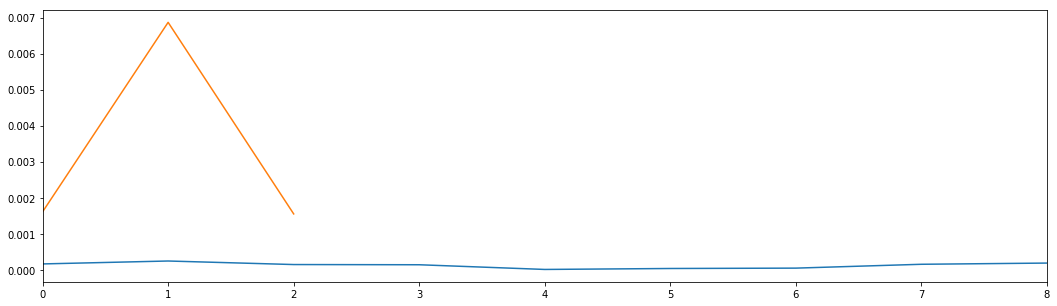

In [12]:
# anomaly score of vn2 and va dataset
pd.Series(normal_score).plot(figsize=(18,5))
pd.Series(abnormal_score).plot()

# test

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/LSTMAutoencoder_v4.ckpt
Model restored.
Initialized


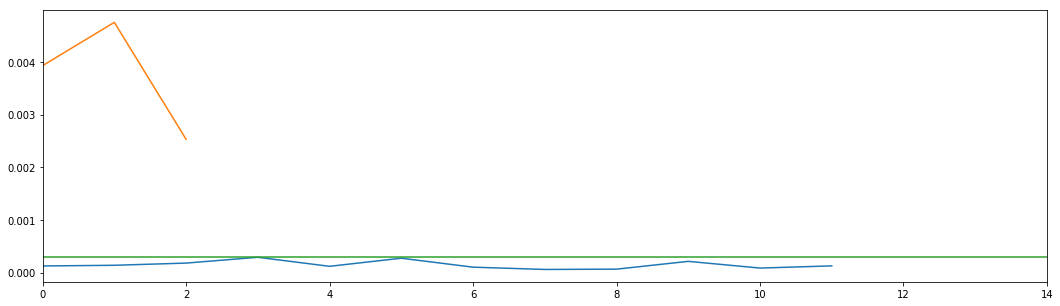

In [13]:
with tf.Session() as sess:
    saver.restore(sess, modlepath) 
    print("Model restored.") 
    print('Initialized')
    
    normal_score = []
    n_in = []
    n_out = []
    a_in = []
    a_out = []
    
    for count in range(len(tn_list)//batch_num):
        normal_sub = np.array(tn_list[count*batch_num:(count+1)*batch_num]) 
        (input_n, output_n) = sess.run([ae.input_, ae.output_], {p_input: normal_sub})
        n_in.append(input_n)
        n_out.append(output_n)
        err_n = abs(input_n-output_n).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_n[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_n[batch] - mu ))
           normal_score.append(s[0])
           
    abnormal_score = []
    for count in range(len(ta_list)//batch_num):
        abnormal_sub = np.array(ta_list[count*batch_num:(count+1)*batch_num]) 
        (input_a, output_a) = sess.run([ae.input_, ae.output_], {p_input: abnormal_sub})
        a_in.append(input_a)
        a_out.append(output_a)
        err_a = abs(input_a-output_a).reshape(-1,step_num)
        for batch in range(batch_num):
           temp = np.dot( (err_a[batch] - mu ).reshape(1,-1)  , sigma.T)
           s = np.dot(temp,(err_a[batch] - mu ))
           abnormal_score.append(s[0])
             


    pd.Series(normal_score).plot(label="normal_score",figsize=(18,5))
    pd.Series(abnormal_score).plot(label="abnormal_score")
    bar = threshold*np.ones(len(normal_score)+len(abnormal_score))
    pd.Series(bar).plot(label="threshold")

# Evaluation

In [14]:
beta = 0.5
tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
fp = len(abnormal_score)-tp
fn = np.array(normal_score)[np.array(normal_score)>threshold].size
tn = len(normal_score)- fn
P = tp/(tp+fp)
R = tp/(tp+fn)
fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
fbeta

1.0

In [15]:
print(tp,fp,tn,fn,P,R)

3 0 12 0 1.0 1.0
